#독립변수중요도분석- 분류분석

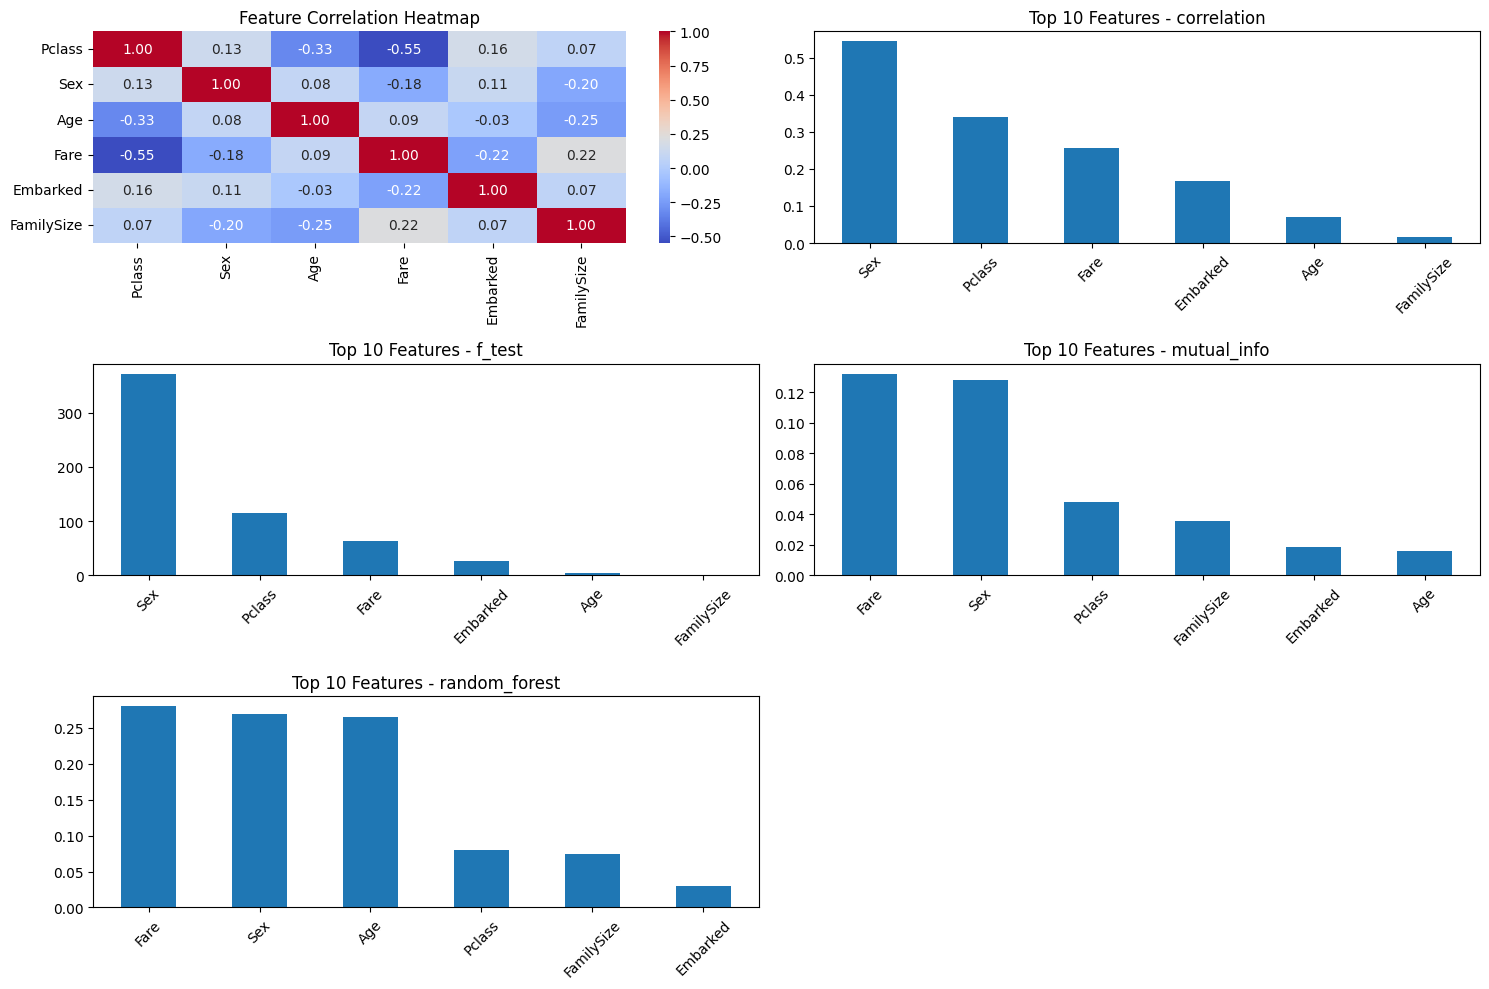


=== 변수 선택 분석 결과 ===

1. 종합 점수 (상위 10개 변수):
Sex           0.979583
Fare          0.656407
Pclass        0.350244
Age           0.263106
Embarked      0.095038
FamilySize    0.086593
dtype: float64

2. 추천 변수 선택:
강력 추천 변수 (종합 점수 상위 25%):
Sex     0.979583
Fare    0.656407
dtype: float64
{'correlation': Sex           0.543351
Pclass        0.338481
Fare          0.257307
Embarked      0.167675
Age           0.069809
FamilySize    0.016639
Name: target, dtype: float64, 'f_test': Sex           372.405724
Pclass        115.031272
Fare           63.030764
Embarked       25.717286
Age             4.353516
FamilySize      0.246193
dtype: float64, 'mutual_info': Fare          0.132356
Sex           0.128402
Pclass        0.048380
FamilySize    0.035397
Embarked      0.018551
Age           0.015638
dtype: float64, 'random_forest': Fare          0.280647
Sex           0.268673
Age           0.265724
Pclass        0.080436
FamilySize    0.074447
Embarked      0.030073
dtype: float64, 'rfe': Pclass  

In [ ]:
#분류분석
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

def analyze_features(X, y, feature_names=None):
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(X.shape[1])]

    # 데이터프레임으로 변환
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=feature_names)

    results = {}

    # 1. 상관관계 분석
    def correlation_analysis():
        if isinstance(y, pd.Series):
            data = X.copy()
            data['target'] = y
        else:
            data = X.copy()
            data['target'] = pd.Series(y)

        correlation = data.corr()['target'].drop('target')
        return correlation.abs().sort_values(ascending=False)

    results['correlation'] = correlation_analysis()

    # 2. ANOVA F-test (범주형 목표변수)
    f_scores, _ = f_classif(X, y)
    results['f_test'] = pd.Series(f_scores, index=feature_names).sort_values(ascending=False)

    # 3. 상호정보량
    mi_scores = mutual_info_classif(X, y)
    results['mutual_info'] = pd.Series(mi_scores, index=feature_names).sort_values(ascending=False)

    # 4. Random Forest Feature Importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    results['random_forest'] = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

    # 5. Recursive Feature Elimination
    rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=len(feature_names)//2)
    rfe.fit(X, y)
    results['rfe'] = pd.Series(rfe.ranking_, index=feature_names).sort_values()

    # 결과 시각화
    plt.figure(figsize=(15, 10))

    # 1. 상관관계 히트맵
    plt.subplot(3, 2, 1)
    sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Heatmap')

    # 2. 각 방법별 특성 중요도
    methods = ['correlation', 'f_test', 'mutual_info', 'random_forest']
    for i, method in enumerate(methods, 1):
        plt.subplot(3, 2, i+1)
        results[method].head(10).plot(kind='bar')
        plt.title(f'Top 10 Features - {method}')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # 종합 점수 계산
    def normalize_scores(scores):
        return (scores - scores.min()) / (scores.max() - scores.min())

    # 각 방법의 결과를 정규화하고 종합
    normalized_scores = pd.DataFrame({
        'Correlation': normalize_scores(results['correlation']),
        'F-test': normalize_scores(results['f_test']),
        'Mutual Info': normalize_scores(results['mutual_info']),
        'Random Forest': normalize_scores(results['random_forest'])
    })

    # 종합 점수 계산 (평균)
    combined_scores = normalized_scores.mean(axis=1).sort_values(ascending=False)

    print("\n=== 변수 선택 분석 결과 ===")
    print("\n1. 종합 점수 (상위 10개 변수):")
    print(combined_scores.head(10))

    print("\n2. 추천 변수 선택:")
    print("강력 추천 변수 (종합 점수 상위 25%):")
    threshold = combined_scores.quantile(0.75)
    print(combined_scores[combined_scores >= threshold])

    return results, combined_scores

df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
# Age 컬럼의 결측값을 평균으로 대치
d_mean = df['Age'].mean()
df['Age'].fillna(d_mean, inplace=True)

# 출발항구코드 컬럼의 결측값을 최빈값으로 대치
d_mode = df['Embarked'].mode()[0]
df['Embarked'].fillna(d_mode, inplace=True)

# Sex 컬럼값을 1과 0으로 레이블인코딩
from sklearn.preprocessing import LabelEncoder
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])

# Embarked(출발항구코드) 컬럼값을 0,1,2로 레이블인코딩
df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])

# SibSp(형제배우자수), Parch(부모자녀수)의 값을 더해서 FamilySize 컬럼(파생변수)을 생성한다
df['FamilySize'] = df['SibSp'] + df['Parch']

X = df[['Pclass','Sex','Age','Fare','Embarked','FamilySize']]
y = df['Survived']  #종속변수 범주형

feature_names = ['Pclass','Sex','Age','Fare','Embarked','FamilySize']

# 변수 선택 분석 실행
results, combined_scores = analyze_features(X, y, feature_names)

print(results, combined_scores)

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

def compare_models(X_train, X_test, y_train, y_test):
    """
    여러 모델을 비교하고 최적의 하이퍼파라미터를 찾는 함수

    Parameters:
    X_train, X_test: 학습 및 테스트 특성 데이터
    y_train, y_test: 학습 및 테스트 레이블 데이터

    Returns:
    best_model: 최적의 모델
    results_df: 모델 비교 결과
    """

    # 1. 모델과 하이퍼파라미터 정의
    models = {
        'Logistic Regression': {
            'model': LogisticRegression(),
            'params': {
                'C': [0.001, 0.01, 0.1, 1, 10],
                'max_iter': [1000]
            }
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(),
            'params': {
                'max_depth': [3, 5, 7, 10],
                'min_samples_split': [2, 5, 10]
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5]
            }
        },
        'SVM': {
            'model': SVC(),
            'params': {
                'C': [0.1, 1, 10],
                'kernel': ['rbf', 'linear']
            }
        },
        'KNN': {
          'model': KNeighborsClassifier(),
          'params': {
              'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform', 'distance']
          }
      }
    }

    # 2. 각 모델별로 GridSearchCV 수행
    results = []
    best_score = 0
    best_model = None

    for name, model_info in models.items():
        grid_search = GridSearchCV(
            model_info['model'],
            model_info['params'],
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )

        # 모델 학습
        grid_search.fit(X_train, y_train)

        # 테스트 세트로 성능 평가
        y_pred = grid_search.predict(X_test)
        test_score = accuracy_score(y_test, y_pred)

        # 결과 저장
        results.append({
            'Model': name,
            'Best Parameters': grid_search.best_params_,
            'Cross-val Score': grid_search.best_score_,
            'Test Score': test_score
        })

        # 최고 성능 모델 저장
        if test_score > best_score:
            best_score = test_score
            best_model = grid_search.best_estimator_

    # 결과를 데이터프레임으로 변환
    results_df = pd.DataFrame(results)

    return best_model, results_df

# 사용 예시

# 데이터 준비
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=1000, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 비교 실행
best_model, results = compare_models(X_train, X_test, y_train, y_test)

# 결과 출력
print("\n모델 비교 결과:")
print(results)

print("\n최적 모델 성능 보고서:")
print(best_model)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


모델 비교 결과:
                 Model                                    Best Parameters  \
0  Logistic Regression                       {'C': 0.1, 'max_iter': 1000}   
1        Decision Tree           {'max_depth': 5, 'min_samples_split': 2}   
2        Random Forest  {'max_depth': 7, 'min_samples_split': 2, 'n_es...   
3                  SVM                     {'C': 0.1, 'kernel': 'linear'}   
4                  KNN           {'n_neighbors': 9, 'weights': 'uniform'}   

   Cross-val Score  Test Score  
0          0.86875       0.865  
1          0.89000       0.865  
2          0.88375       0.890  
3          0.87375       0.880  
4          0.83500       0.800  

최적 모델 성능 보고서:
RandomForestClassifier(max_depth=7)
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        93
           1       0.94      0.85      0.89       107

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weigh

# 독립변수중요도분석(회귀)

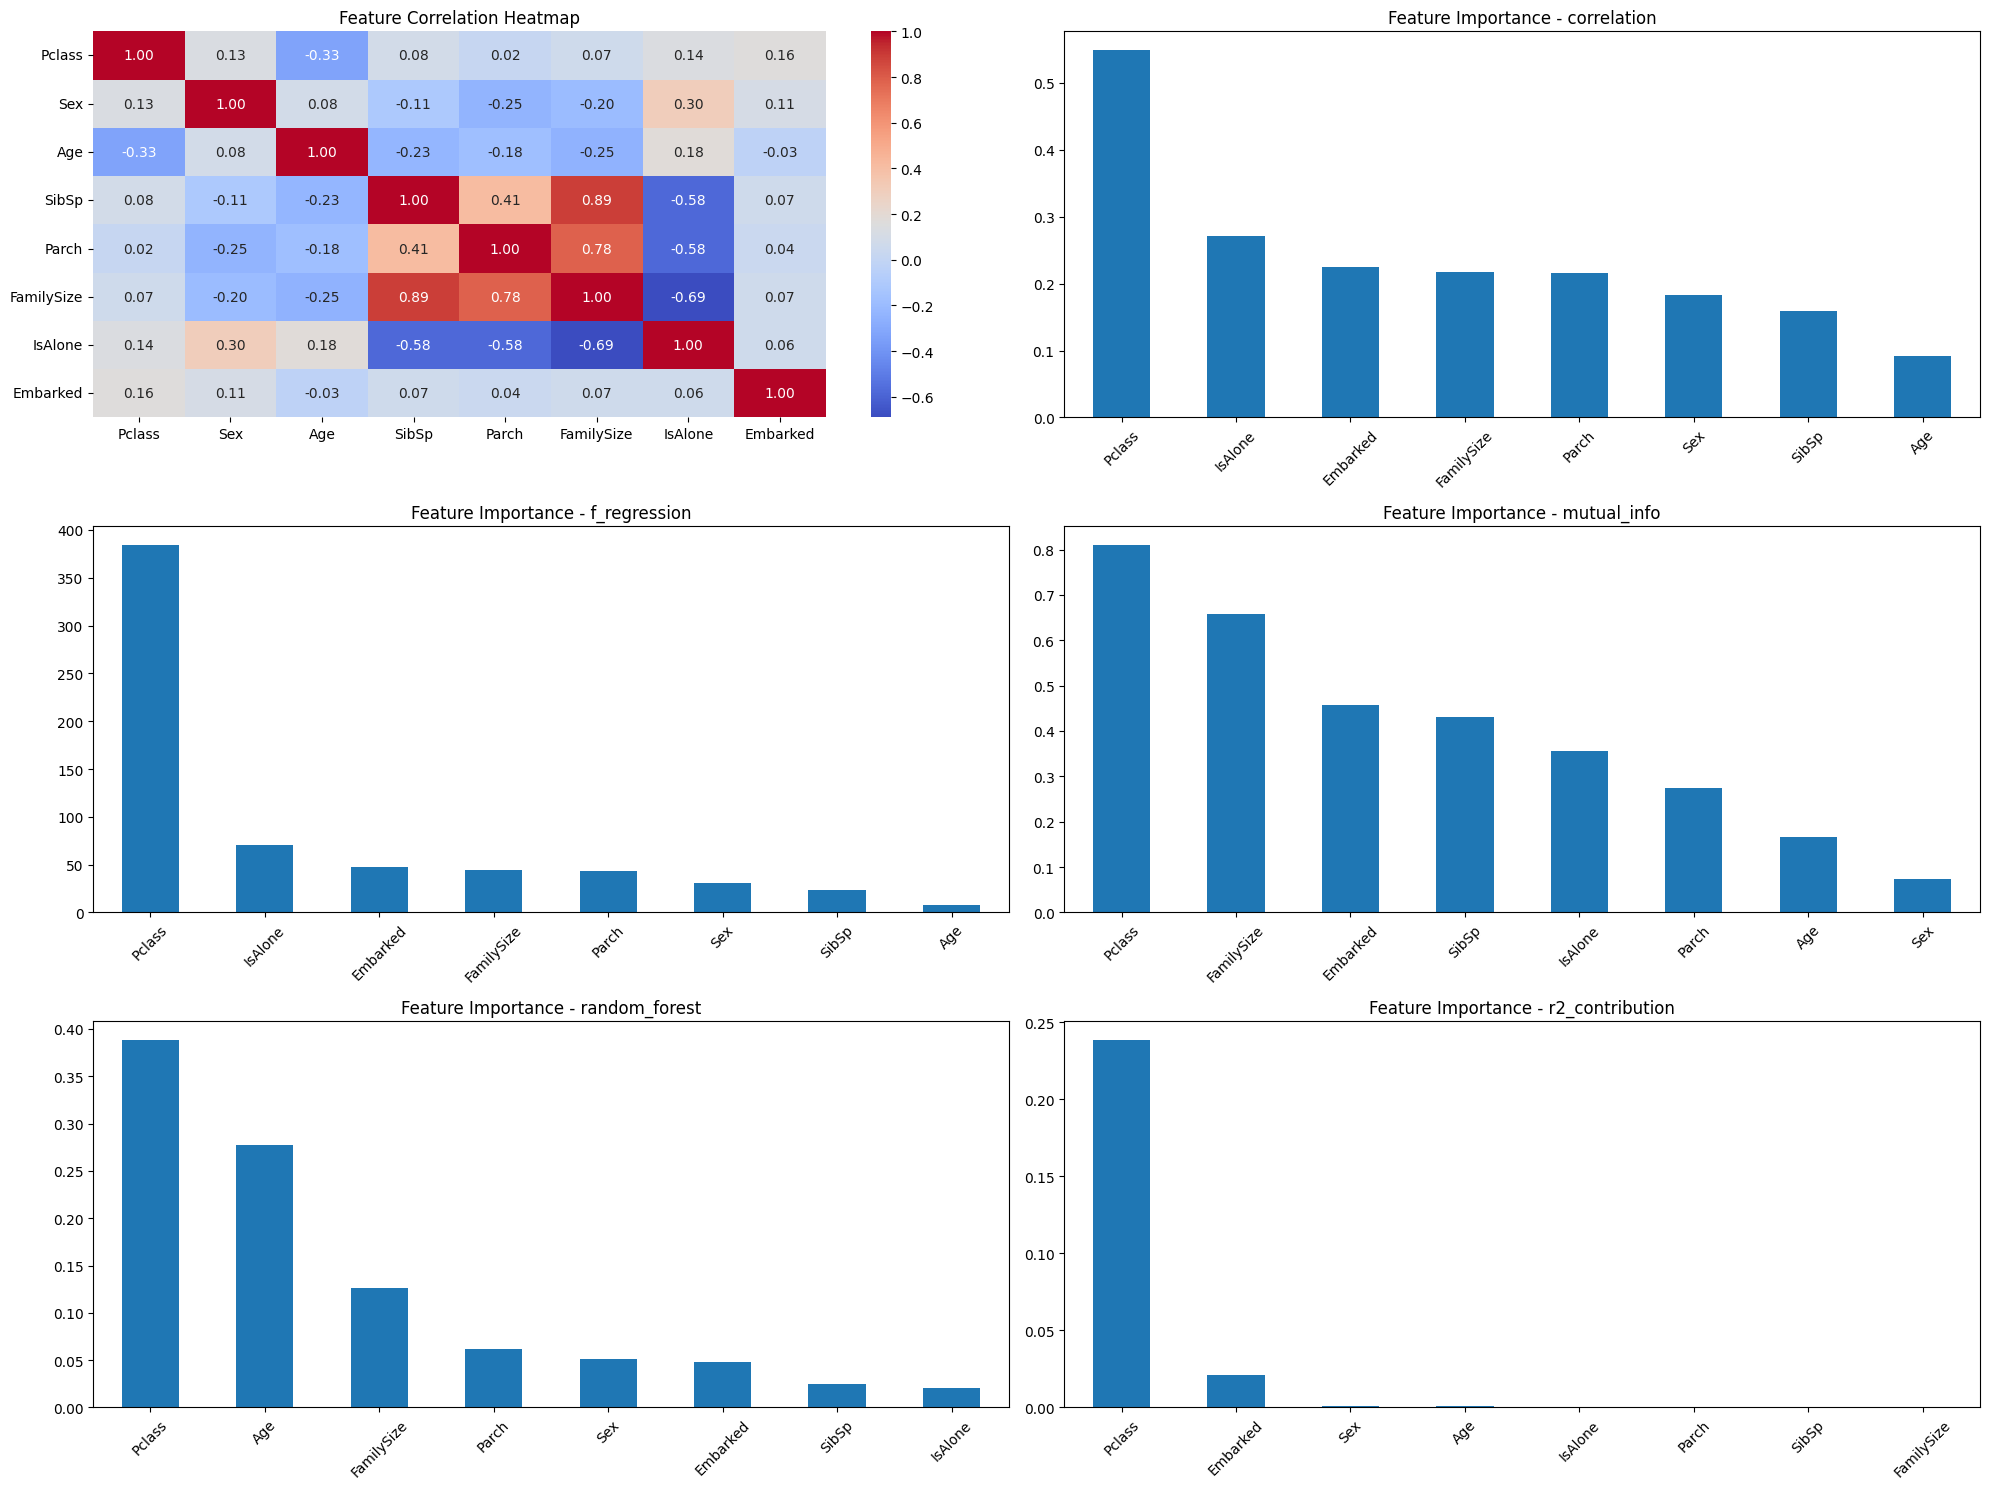


=== 변수 중요도 분석 결과 ===

1. 종합 점수 (전체 변수):
Pclass        1.000000
FamilySize    0.289979
Embarked      0.216262
IsAlone       0.188994
Age           0.165193
Parch         0.150331
SibSp         0.137251
Sex           0.069611
dtype: float64

2. 추천 변수:
강력 추천 변수 (종합 점수 상위 25%):
Pclass        1.000000
FamilySize    0.289979
dtype: float64

3. 다중공선성 분석 (VIF):
     Variable       VIF
3       SibSp       inf
4       Parch       inf
5  FamilySize       inf
0      Pclass  6.791343
6     IsAlone  5.245655
7    Embarked  4.751561
2         Age  4.151942
1         Sex  3.211525


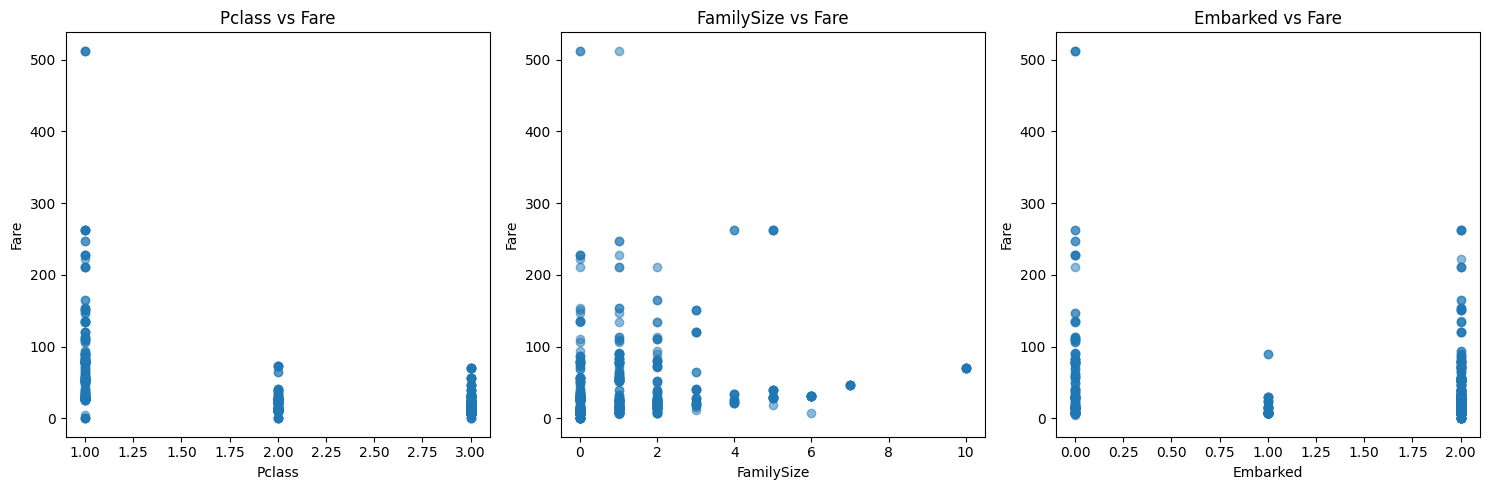


변수 설명:
Pclass: 객실 등급 (1=1등급, 2=2등급, 3=3등급)
Sex: 성별 (0=여성, 1=남성)
Age: 나이
SibSp: 동승한 형제자매, 배우자 수
Parch: 동승한 부모, 자녀 수
FamilySize: 전체 가족 구성원 수 (SibSp + Parch)
IsAlone: 혼자 탑승했는지 여부 (0=가족과 동승, 1=혼자)
Embarked: 승선 항구 (0=C, 1=Q, 2=S)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드 및 전처리
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

# Age 컬럼의 결측값을 평균으로 대치
df['Age'].fillna(df['Age'].mean(), inplace=True)

# Embarked 컬럼의 결측값을 최빈값으로 대치
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# 범주형 변수 전처리 (LabelEncoder 사용)
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])  # male=1, female=0
df['Embarked'] = le.fit_transform(df['Embarked'])

# 파생변수 생성
df['FamilySize'] = df['SibSp'] + df['Parch']
df['IsAlone'] = (df['FamilySize'] == 0).astype(int)

# 특성 선택
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'FamilySize', 'IsAlone', 'Embarked']
X = df[features]
y = df['Fare']  # Fare를 목표변수로 사용--연속형

def analyze_regression_features(X, y, feature_names=None):
    """
    회귀 문제에서 독립변수의 중요도를 분석하는 함수

    Parameters:
    X: 특성 데이터 (DataFrame 또는 numpy array)
    y: 연속형 목표변수
    feature_names: 특성 이름 리스트 (기본값: None)
    """
    if feature_names is None:
        feature_names = X.columns.tolist()

    results = {}

    # 1. 상관관계 분석
    def correlation_analysis():
        if isinstance(y, pd.Series):
            data = X.copy()
            data['target'] = y
        else:
            data = X.copy()
            data['target'] = pd.Series(y)

        correlation = data.corr()['target'].drop('target')
        return correlation.abs().sort_values(ascending=False)

    results['correlation'] = correlation_analysis()

    # 2. F-regression
    f_scores, _ = f_regression(X, y)
    results['f_regression'] = pd.Series(f_scores, index=feature_names).sort_values(ascending=False)

    # 3. 상호정보량
    mi_scores = mutual_info_regression(X, y)
    results['mutual_info'] = pd.Series(mi_scores, index=feature_names).sort_values(ascending=False)

    # 4. Random Forest Feature Importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    results['random_forest'] = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

    # 5. R-squared 기여도
    def r2_contribution():
        base_r2 = LinearRegression().fit(X, y).score(X, y)
        contributions = {}

        for feature in feature_names:
            X_temp = X.drop(columns=[feature])
            r2_without = LinearRegression().fit(X_temp, y).score(X_temp, y)
            contributions[feature] = base_r2 - r2_without

        return pd.Series(contributions).sort_values(ascending=False)

    results['r2_contribution'] = r2_contribution()

    # 결과 시각화
    plt.figure(figsize=(20, 15))

    # 1. 상관관계 히트맵
    plt.subplot(3, 2, 1)
    sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Heatmap')

    # 2. 각 방법별 특성 중요도
    methods = ['correlation', 'f_regression', 'mutual_info', 'random_forest', 'r2_contribution']
    for i, method in enumerate(methods, 1):
        plt.subplot(3, 2, i+1)
        results[method].plot(kind='bar')
        plt.title(f'Feature Importance - {method}')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # 종합 점수 계산
    def normalize_scores(scores):
        return (scores - scores.min()) / (scores.max() - scores.min())

    # 각 방법의 결과를 정규화하고 종합
    normalized_scores = pd.DataFrame({
        'Correlation': normalize_scores(results['correlation']),
        'F-regression': normalize_scores(results['f_regression']),
        'Mutual Info': normalize_scores(results['mutual_info']),
        'Random Forest': normalize_scores(results['random_forest']),
        'R2 Contribution': normalize_scores(results['r2_contribution'])
    })

    # 종합 점수 계산 (평균)
    combined_scores = normalized_scores.mean(axis=1).sort_values(ascending=False)

    print("\n=== 변수 중요도 분석 결과 ===")
    print("\n1. 종합 점수 (전체 변수):")
    print(combined_scores)

    print("\n2. 추천 변수:")
    print("강력 추천 변수 (종합 점수 상위 25%):")
    threshold = combined_scores.quantile(0.75)
    print(combined_scores[combined_scores >= threshold])

    # 다중공선성 분석
    def calculate_vif(X):
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        return vif_data.sort_values('VIF', ascending=False)

    print("\n3. 다중공선성 분석 (VIF):")
    print(calculate_vif(X))

    # 추가: 목표변수와의 관계 시각화
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(combined_scores.head(3).index, 1):
        plt.subplot(1, 3, i)
        plt.scatter(X[feature], y, alpha=0.5)
        plt.xlabel(feature)
        plt.ylabel('Fare')
        plt.title(f'{feature} vs Fare')
    plt.tight_layout()
    plt.show()

    return results, combined_scores

# 변수 중요도 분석 실행
results, combined_scores = analyze_regression_features(X, y)

# 변수별 설명
print("\n변수 설명:")
print("Pclass: 객실 등급 (1=1등급, 2=2등급, 3=3등급)")
print("Sex: 성별 (0=여성, 1=남성)")
print("Age: 나이")
print("SibSp: 동승한 형제자매, 배우자 수")
print("Parch: 동승한 부모, 자녀 수")
print("FamilySize: 전체 가족 구성원 수 (SibSp + Parch)")
print("IsAlone: 혼자 탑승했는지 여부 (0=가족과 동승, 1=혼자)")
print("Embarked: 승선 항구 (0=C, 1=Q, 2=S)")

# 회귀모델 성능평가

In [2]:
#회귀 모델을 비교하고 최적의 하이퍼파라미터를 찾기
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

def compare_regression_models(X_train, X_test, y_train, y_test):
    """
    여러 회귀 모델을 비교하고 최적의 하이퍼파라미터를 찾는 함수

    Parameters:
    X_train, X_test: 학습 및 테스트 특성 데이터
    y_train, y_test: 학습 및 테스트 타겟 데이터

    Returns:
    best_model: 최적의 모델
    results_df: 모델 비교 결과
    """

    # 1. 모델과 하이퍼파라미터 정의
    models = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': {}  # 하이퍼파라미터 없음
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
            }
        },
        'Lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                'max_iter': [3000]
            }
        },
        'Decision Tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'max_depth': [3, 5, 7, 10],
                'min_samples_split': [2, 5, 10]
            }
        },
        'Random Forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5]
            }
        },
        'SVR': {
            'model': SVR(),
            'params': {
                'C': [0.1, 1, 10],
                'kernel': ['rbf', 'linear']
            }
        },
        'KNN': {
            'model': KNeighborsRegressor(),
            'params': {
                'n_neighbors': [3, 5, 7, 9],
                'weights': ['uniform', 'distance']
            }
        }
    }

    # 2. 각 모델별로 GridSearchCV 수행
    results = []
    best_score = float('-inf')  # R2 점수 기준
    best_model = None

    for name, model_info in models.items():
        # LinearRegression은 하이퍼파라미터가 없으므로 별도 처리
        if name == 'Linear Regression':
            model = model_info['model']
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # 평가 지표 계산
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            results.append({
                'Model': name,
                'Best Parameters': 'N/A',
                'R2 Score': r2,
                'RMSE': rmse,
                'MAE': mae
            })

            if r2 > best_score:
                best_score = r2
                best_model = model

        else:
            grid_search = GridSearchCV(
                model_info['model'],
                model_info['params'],
                cv=5,
                scoring='r2',
                n_jobs=-1
            )

            # 모델 학습
            grid_search.fit(X_train, y_train)

            # 테스트 세트로 성능 평가
            y_pred = grid_search.predict(X_test)

            # 평가 지표 계산
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # 결과 저장
            results.append({
                'Model': name,
                'Best Parameters': grid_search.best_params_,
                'R2 Score': r2,
                'RMSE': rmse,
                'MAE': mae
            })

            # 최고 성능 모델 저장
            if r2 > best_score:
                best_score = r2
                best_model = grid_search.best_estimator_

    # 결과를 데이터프레임으로 변환
    results_df = pd.DataFrame(results)

    return best_model, results_df

# 사용 예시

# 데이터 준비
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# 회귀 데이터 생성
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
# X(독립변수):1,000개의 샘플과 20개의 독립변수를 가진 행렬 (1000×20) 형태
# y(종속변수)는 1,000개의 연속형 숫자로 이루어진 벡터
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 비교 실행
best_model, results = compare_regression_models(X_train, X_test, y_train, y_test)

# 결과 출력
print("\n모델 비교 결과:")
print(results.sort_values(by='R2 Score', ascending=False))

print("\n최적 모델:")
print(best_model)

# 최적 모델의 성능 평가
y_pred = best_model.predict(X_test)
print("\n최적 모델 성능:")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")  #작을수록 좋음
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")


모델 비교 결과:
               Model                                    Best Parameters  \
2              Lasso                 {'alpha': 0.001, 'max_iter': 3000}   
1              Ridge                                   {'alpha': 0.001}   
0  Linear Regression                                                N/A   
5                SVR                      {'C': 10, 'kernel': 'linear'}   
4      Random Forest  {'max_depth': 7, 'min_samples_split': 2, 'n_es...   
6                KNN          {'n_neighbors': 9, 'weights': 'distance'}   
3      Decision Tree           {'max_depth': 5, 'min_samples_split': 5}   

   R2 Score        RMSE         MAE  
2  1.000000    0.106699    0.084423  
1  1.000000    0.106894    0.084678  
0  1.000000    0.106901    0.084678  
5  1.000000    0.107015    0.084743  
4  0.803552   87.202353   69.269401  
6  0.628719  119.882445   96.343928  
3  0.512409  137.382671  110.833984  

최적 모델:
Lasso(alpha=0.001, max_iter=3000)

최적 모델 성능:
R2 Score: 1.0000
RMSE: 0.1067
M

회귀 모델의 성능 평가 - 4가지 지표  
R² Score (결정계수)  
R²는 모델이 데이터 변동성을 얼마나 잘 설명하는지를 나타내는 지표입니다. 값의 범위는 0에서 1 사이이며, 1에 가까울수록 모델이 데이터를 잘 설명하는 것입니다. R²가 0이면 모델이 평균값으로 예측하는 것과 같고, 1이면 모든 데이터를 정확히 예측하는 것입니다.  
RMSE (Root Mean Square Error, 평균 제곱근 오차)
RMSE는 예측값과 실제값 간의 차이를 제곱한 후 평균을 내고, 다시 제곱근을 취한 값입니다. 값이 작을수록 모델의 예측이 실제값에 가깝다는 것을 의미합니다. RMSE는 단위가 원래 데이터와 동일하므로 해석이 용이합니다.  
MAE (Mean Absolute Error, 평균 절대 오차)
MAE는 예측값과 실제값 간의 절대적인 차이의 평균입니다. RMSE와 마찬가지로 값이 작을수록 모델의 성능이 좋음을 나타냅니다. MAE는 이상치의 영향을 덜 받기 때문에, RMSE보다 더 강건한 지표로 여겨질 수 있습니다.    
MSE (Mean Squared Error, 평균 제곱 오차)
MSE는 예측값과 실제값 간의 차이를 제곱한 후 평균을 내는 지표입니다. RMSE와 비슷하지만, 제곱근을 취하지 않기 때문에 단위가 원래 데이터의 제곱이 됩니다. 값이 작을수록 모델의 예측이 더 정확하다는 것을 나타냅니다.


# pickle

In [ ]:
import pickle

#저장된 모델 파일 경로
model_file='path/to/your/model.pkl'

#모델불러오기
with open(model_file,'rb') as file:
  model=pickle.load(file)

#모델 사용 예시
predictions=model.predict(X_new)  # X_new는 새 데이터

# joblib

In [ ]:
from joblib import load

#모델불러오기
model=load('model.joblib')

#모델 사용 예시
predictions=model.predict(X_new)  # X_new는 새 데이터